In [72]:
!pip install faker pandas numpy scikit-learn shap matplotlib seaborn joblib

In [74]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

In [76]:
fake = Faker()
random.seed(42)
np.random.seed(42)

NUM_CLINICS = 30
NUM_ROWS = 1000
CLINIC_NAMES = [f"Clinic_{i+1}" for i in range(NUM_CLINICS)]
CLINIC_TYPES = ["General", "Maternal", "Pediatric", "Chronic", "Emergency"]
URBAN_RURAL = ["Urban", "Rural"]
WEATHER_CONDITIONS = ["Clear", "Rain", "Storm", "Cloudy"]
APPOINTMENT_TYPES = ["Routine", "Follow-up", "Urgent"]
WALK_IN_POLICY = ["Strict", "Moderate", "Open"]
TIMES_OF_DAY = ["Morning", "Afternoon", "Evening"]

def generate_date(): 
    return fake.date_between(start_date="-6M", end_date="today")

data = []

for _ in range(NUM_ROWS):
    date = generate_date()
    appts = random.randint(30, 120)
    walk_ins = random.randint(5, 30)
    emergencies = random.randint(0, 5)
    staff_count = random.randint(3, 10)

    cancellation_rate = round(random.uniform(0.02, 0.2), 2)
    cancellations = int(cancellation_rate * appts)
    no_shows = int(np.clip(np.random.normal(appts * 0.1, 3), 0, appts * 0.3))
    staff_nurses = random.randint(1, staff_count - 1)
    staff_doctors = staff_count - staff_nurses
    triage_score_avg = round(np.clip(np.random.normal(2.5, 0.7), 1.0, 5.0), 2)
    power = random.choices([0, 1], weights=[0.9, 0.1])[0]
    equipment = random.choices([0, 1], weights=[0.85, 0.15])[0]

    patients_served = appts - no_shows - cancellations + walk_ins + emergencies
    wait = 15 + (appts * 0.3) - (staff_count * 2) + (walk_ins * 0.5) + (emergencies * 1.5)
    wait += 20 * power + 15 * equipment
    avg_wait_time = round(max(5, wait + np.random.normal(0, 5)), 2)

    data.append({
        "date": date,
        "day_of_week": date.strftime("%A"),
        "time_of_day": random.choice(TIMES_OF_DAY),
        "clinic": random.choice(CLINIC_NAMES),
        "clinic_type": random.choice(CLINIC_TYPES),
        "urban_rural": random.choice(URBAN_RURAL),
        "appointment_type": random.choice(APPOINTMENT_TYPES),
        "appointments": appts,
        "avg_appointment_duration": round(random.uniform(10, 30), 1),
        "clinic_open_hours": random.choice([8, 9, 10]),
        "appointment_lead_time": random.randint(0, 30),
        "walk_ins": walk_ins,
        "emergencies": emergencies,
        "staff_count": staff_count,
        "weather": random.choice(WEATHER_CONDITIONS),
        "transport_access_score": round(random.uniform(0.2, 1.0), 2),
        "walk_in_policy": random.choice(WALK_IN_POLICY),
        "cancellation_rate": cancellation_rate,
        "cancellations": cancellations,
        "no_shows": no_shows,
        "no_show_rate": round(no_shows / appts, 2),
        "staff_nurses": staff_nurses,
        "staff_doctors": staff_doctors,
        "triage_score_avg": triage_score_avg,
        "power_outage": power,
        "equipment_downtime": equipment,
        "patients_served": patients_served,
        "avg_wait_time": avg_wait_time,
        "efficiency_score": round(((patients_served / staff_count) - (avg_wait_time / 10)), 2),
        "staff_per_patient": round(staff_count / max(patients_served, 1), 2),
        "complaints_received": int(max(0, np.random.normal(appts * 0.05 + avg_wait_time * 0.2, 2)))
    })

df = pd.DataFrame(data)

In [78]:
target = "avg_wait_time"
drop_cols = ["avg_wait_time", "date", "clinic", "complaints_received", "patients_served"]
X = df.drop(columns=drop_cols)
y = df[target]

categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", Ridge())
])

ridge_param_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

best_ridge_model = ridge_grid_search.best_estimator_
print("Best alpha for Ridge:", ridge_grid_search.best_params_)

Best alpha for Ridge: {'ridge__alpha': 0.1}


In [81]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("randomforestregressor", RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['appointments',
                                                   'avg_appointment_duration',
                                                   'clinic_open_hours',
                                                   'appointment_lead_time',
                                                   'walk_ins', 'emergencies',
                                                   'staff_count',
                                                   'transport_access_score',
                                                   'cancellation_rate',
                                                   'cancellations', 'no_shows',
                                                   'no_show_rate',
                                                   'staff_nurses',
                                                   'staff_doctors',
                                                   'triage_score_avg',
                                                   'power_outage',
                                                   'equipment_downtime',
                                                   'efficiency_score',
                                                   'staff_per_patient']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day_of_week', 'time_of_day',
                                                   'clinic_type', 'urban_rural',
                                                   'appointment_type',
                                                   'weather',
                                                   'walk_in_policy'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [84]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_test, y_test, name="Model"):
    preds = model.predict(X_test)
    print(f"{name} Evaluation:")
    print(f"  MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"  RMSE: {root_mean_squared_error(y_test, preds):.2f}")
    print(f"  R2: {r2_score(y_test, preds):.2f}\n")

evaluate_model(best_ridge_model, X_test, y_test, "Ridge Regression")
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

Ridge Regression Evaluation:
  MAE: 4.41
  RMSE: 5.33
  R2: 0.84

Random Forest Evaluation:
  MAE: 4.52
  RMSE: 5.78
  R2: 0.81



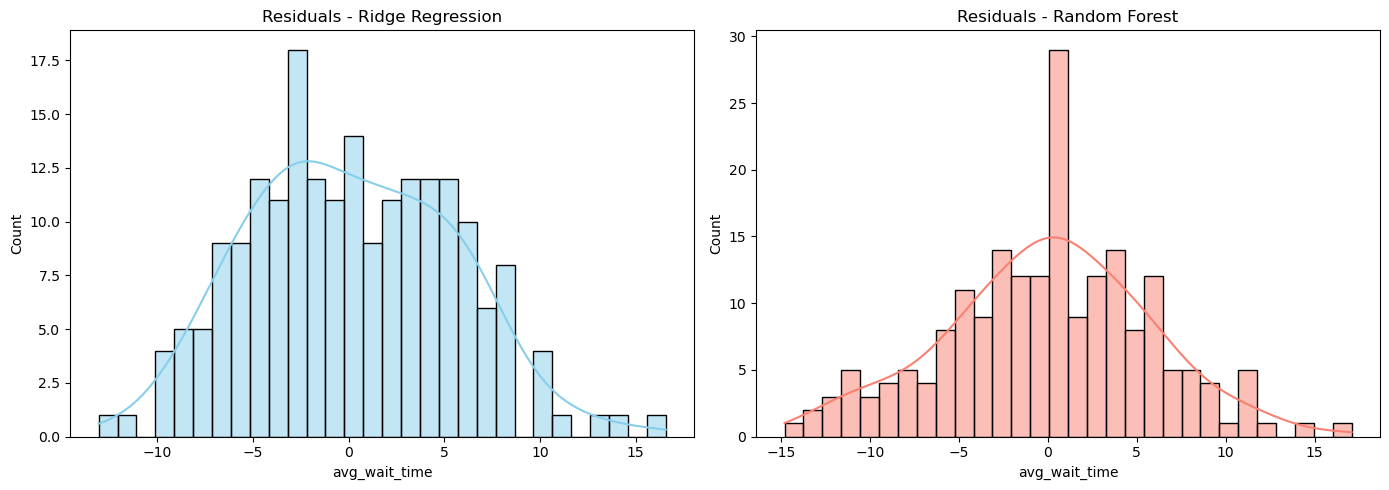

In [85]:
y_pred_ridge = best_ridge_model.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

residuals_ridge = y_test - y_pred_ridge
residuals_rf = y_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals_ridge, kde=True, bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Residuals - Ridge Regression")

sns.histplot(residuals_rf, kde=True, bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Residuals - Random Forest")

plt.tight_layout()
plt.show()

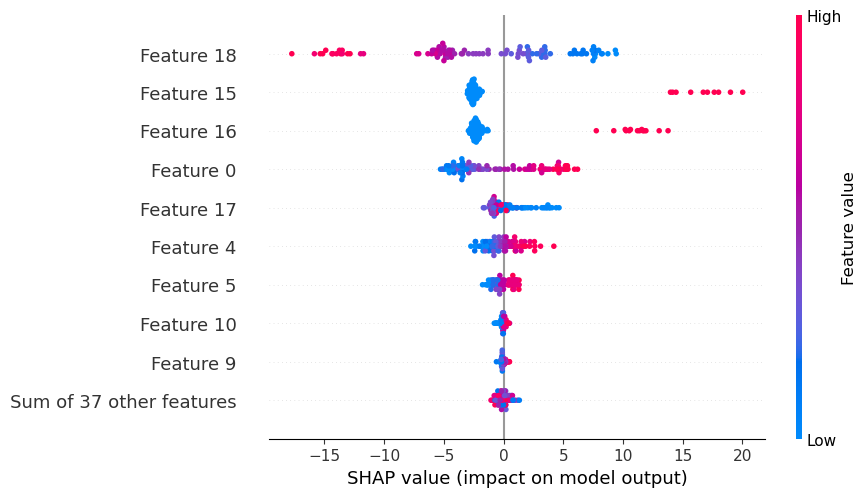

In [88]:
cat_features = rf_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_features)

rf_model_only = rf_pipeline.named_steps["randomforestregressor"]
X_test_preprocessed = rf_pipeline.named_steps["preprocessor"].transform(X_test)

explainer = shap.Explainer(rf_model_only, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed[:100], check_additivity=False)

shap.plots.beeswarm(shap_values)

In [90]:
df.to_csv("clinic_data.csv", index=False)
joblib.dump(best_ridge_model, "ridge_model.joblib")
joblib.dump(rf_pipeline, "rf_model.joblib")

print("Saved files:")
print("- clinic_data.csv")
print("- ridge_model.joblib")
print("- rf_model.joblib")

Saved files:
- clinic_data.csv
- ridge_model.joblib
- rf_model.joblib
